# Integrating scCAT-seq cell lines

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
import sknetwork

In [5]:
import matplotlib.pyplot as plt

## Load data

In [6]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

In [7]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=100)
np.sum(rna.var.highly_variable)

100

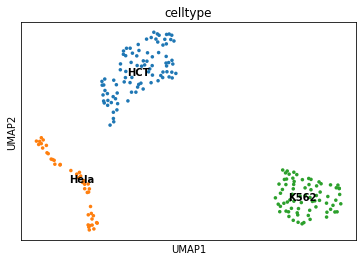

In [8]:
# Umap
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50)

## Preprocess ATAC

In [9]:
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1, n_top_genes=100)
np.sum(atac.var.highly_variable)

100

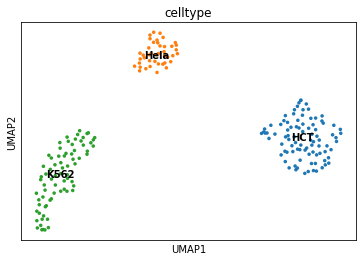

In [10]:
# Umap
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50)

In [11]:
eps = .1
latent_dim = 10
rho_h = .05
rho_w = .05

In [12]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, lazy=False, cost='cosine', pca_cost=False)

In [13]:
nmf.fit_transform(mdata, max_iter_inner=1_000, max_iter=100, device='cpu', dtype=torch.float, lr=1, tol_inner=1e-8, tol_outer=1e-5)

 36%|███▌      | 72/200 [03:38<06:28,  3.04s/it, loss=-0.18616284, loss_inner=0.4033559, inner_steps=123, gpu_memory_allocated=0]


## Convergence plots

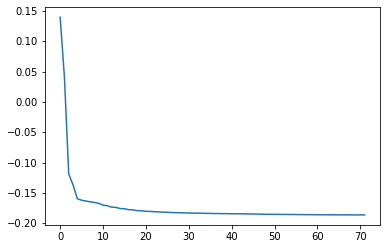

In [14]:
plt.plot(nmf.losses)

## Viz

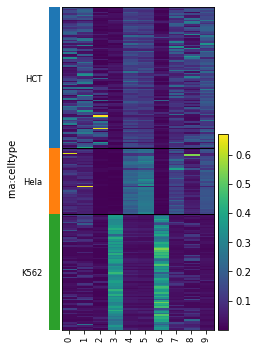

In [15]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

In [16]:
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)

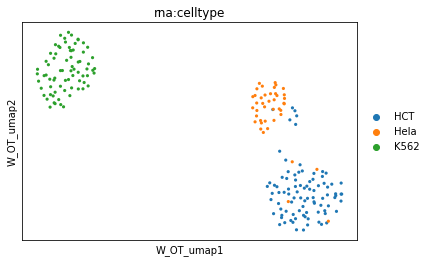

In [17]:
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Clustering

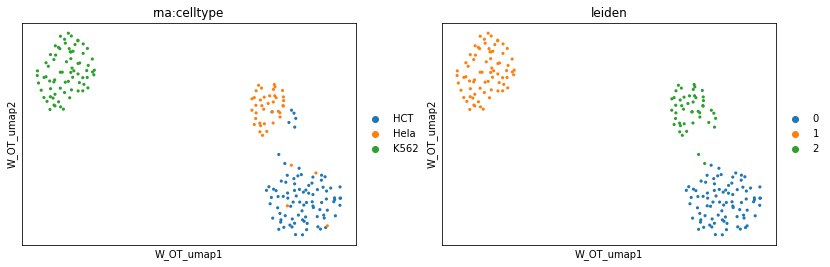

In [18]:
tl.leiden(mdata, resolution=.1)
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=40)

## Enrichment

In [19]:
tl.enrich(mdata, mod='rna', uns='H_OT', n_genes=700, sources=['GO:MF', 'GO:CC', 'GO:BP'], ordered=True);

                                 name   p_value        query
0                  CRLF-CLCF1 complex  0.035390  dimension 5
1            ureteric bud development  0.048244  dimension 5
2             membrane-enclosed lumen  0.048749  dimension 4
3                     organelle lumen  0.048749  dimension 4
4       intracellular organelle lumen  0.048749  dimension 4
5  mesonephric epithelium development  0.049292  dimension 5
